<a href="https://colab.research.google.com/github/ikszn/AML/blob/main/V2GPotentialvF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STREAMLINED V2G DATA PIPELINE
============================
Clean pipeline: Raw Data → Validated Data → Focused EDA → Scenario Ready

Purpose: Sharp, efficient EDA that informs scenario analysis without overwhelming
Target: Dissertation-quality data pipeline that flows smoothly

# CELL 1: IMPORTS AND SETUP


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print("📊 Ready to process V2G data for dissertation analysis")

✅ Libraries imported successfully
📊 Ready to process V2G data for dissertation analysis


# CELL 2: LOAD YOUR RAW DATA


In [12]:
# Load your charging session data
raw_df = pd.read_csv('/content/evchargedata.csv')  # UPDATE THIS PATH

print(f"📁 Raw data loaded: {raw_df.shape[0]:,} records, {raw_df.shape[1]} columns")
print(f"📅 Columns: {list(raw_df.columns)}")
print("\n🔍 First few rows:")
raw_df.head()

📁 Raw data loaded: 76,698 records, 5 columns
📅 Columns: ['ParticipantID', 'BatteryChargeStartDate', 'BatteryChargeStopDate', 'Starting SoC (of 12)', 'Ending SoC (of 12)']

🔍 First few rows:


,ParticipantID,BatteryChargeStartDate,BatteryChargeStopDate,Starting SoC (of 12),Ending SoC (of 12)
0,GC10,2014-02-16 16:05:00.000,2014-02-16 17:05:00.000,1,11
1,GC10,2014-02-16 18:20:00.000,2014-02-16 19:00:00.000,2,11
2,GC10,2014-02-17 08:10:00.000,2014-02-17 15:57:00.000,4,12
3,GC10,2014-02-18 07:41:00.000,2014-02-18 09:52:00.000,5,8
4,GC10,2014-02-18 15:36:00.000,2014-02-18 15:39:00.000,4,4


# CELL 3: DATA VALIDATION AND BASIC STATS


In [13]:
# Basic validation
total_records = len(raw_df)
unique_vehicles = raw_df['user_id'].nunique() if 'user_id' in raw_df.columns else raw_df.iloc[:, 0].nunique()
missing_data = raw_df.isnull().sum().sum()

print("📊 DATA VALIDATION SUMMARY")
print("=" * 50)
print(f"Total records: {total_records:,}")
print(f"Unique vehicles: {unique_vehicles:,}")
print(f"Missing values: {missing_data:,}")
print(f"Data completeness: {(1 - missing_data/(total_records * len(raw_df.columns)))*100:.1f}%")

if 'start_time' in raw_df.columns:
    print(f"Date range: {raw_df['start_time'].min()} to {raw_df['start_time'].max()}")


📊 DATA VALIDATION SUMMARY
Total records: 76,698
Unique vehicles: 215
Missing values: 0
Data completeness: 100.0%


In [14]:
raw_df

,ParticipantID,BatteryChargeStartDate,BatteryChargeStopDate,Starting SoC (of 12),Ending SoC (of 12)
0,GC10,2014-02-16 16:05:00.000,2014-02-16 17:05:00.000,1,11
1,GC10,2014-02-16 18:20:00.000,2014-02-16 19:00:00.000,2,11
2,GC10,2014-02-17 08:10:00.000,2014-02-17 15:57:00.000,4,12
3,GC10,2014-02-18 07:41:00.000,2014-02-18 09:52:00.000,5,8
4,GC10,2014-02-18 15:36:00.000,2014-02-18 15:39:00.000,4,4
...,...,...,...,...,...
76693,SS206,2015-11-28 18:32:00.000,2015-11-28 21:02:00.000,4,10
76694,ST1074,2015-11-29 14:55:00.000,2015-11-29 19:17:00.000,7,12
76695,ST1062,2015-11-29 06:00:00.000,2015-11-29 09:26:00.000,8,12
76696,BL05,2015-11-28 21:56:00.000,2015-11-29 00:14:00.000,10,12


# CELL 4: DATA PREPROCESSING


In [15]:
print("🔄 Starting data preprocessing...")

# Copy for processing
df = raw_df.copy()

# --- Standardize your original columns (rename) ---
df.rename(columns={
    "ParticipantID": "vehicle_id",
    "BatteryChargeStartDate": "start_time",
    "BatteryChargeStopDate": "end_time",
    "Starting SoC (of 12)": "start_soc",
    "Ending SoC (of 12)": "end_soc",
}, inplace=True)

# Ensure SoC are numeric (in case they came in as strings)
for c in ("start_soc", "end_soc"):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


# Convert datetime columns
for col in ['start_time', 'end_time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])
        print(f"✅ Converted {col} to datetime")

# Calculate duration
if 'start_time' in df.columns and 'end_time' in df.columns:
    df['duration_hours'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600
    print("✅ Calculated session duration")
elif 'duration_hours' not in df.columns:
    print("⚠️ No time columns found - creating dummy duration")
    df['duration_hours'] = 2.0  # Assume 2 hour average

# Set battery capacity (UPDATE THIS FOR YOUR EV TYPE)
BATTERY_CAPACITY_KWH = 60.0

# Convert SoC scales if needed
for col in ['start_soc', 'end_soc']:
    if col in df.columns:
        max_val = df[col].max()
        if max_val <= 12 and max_val > 1:  # 0-12 scale
            print(f"🔄 Converting {col} from 0-12 to 0-100% scale")
            df[col] = (df[col] / 12) * 100
        elif max_val <= 1:  # 0-1 scale
            print(f"🔄 Converting {col} from 0-1 to 0-100% scale")
            df[col] = df[col] * 100
        else:
            print(f"ℹ️ {col} already in 0-100% scale (max: {max_val:.1f})")

# Calculate V2G potential at different comfort levels
comfort_reserves = [20, 40, 60]  # 20%, 40%, 60% battery reserve
if 'start_soc' in df.columns:
    for reserve in comfort_reserves:
        df[f'v2g_kwh_reserve_{reserve}pc'] = np.maximum(0,
            (df['start_soc'] - reserve) * BATTERY_CAPACITY_KWH / 100)
    print(f"✅ Calculated V2G potential at {comfort_reserves}% reserve levels")
else:
    print("⚠️ No start_soc column - skipping V2G calculation")

# Add time features
if 'start_time' in df.columns:
    df['start_hour'] = df['start_time'].dt.hour
    df['start_weekday'] = df['start_time'].dt.weekday
    df['is_weekend'] = df['start_weekday'] >= 5
    df['start_month'] = df['start_time'].dt.month
    print("✅ Added time-based features")

# Data quality filtering
print("🧹 Applying data quality filters...")
initial_count = len(df)

# Remove invalid sessions
valid_sessions = (
    (df['duration_hours'] >= 0.25) &    # At least 15 minutes
    (df['duration_hours'] <= 48)       # Less than 2 days
)

# Add SoC filters if available
if 'start_soc' in df.columns and 'end_soc' in df.columns:
    valid_sessions = valid_sessions & (
        (df['start_soc'] >= 0) & (df['start_soc'] <= 100) &
        (df['end_soc'] >= 0) & (df['end_soc'] <= 100)
    )

df = df[valid_sessions].copy()

retention_rate = len(df) / initial_count
print(f"✅ Data cleaning complete")
print(f"   Retained: {len(df):,} sessions ({retention_rate*100:.1f}%)")
print(f"   Removed: {initial_count - len(df):,} invalid sessions")

print(f"\n🎯 Ready for EDA with {len(df):,} clean records")

🔄 Starting data preprocessing...
✅ Converted start_time to datetime
✅ Converted end_time to datetime
✅ Calculated session duration
🔄 Converting start_soc from 0-12 to 0-100% scale
🔄 Converting end_soc from 0-12 to 0-100% scale
✅ Calculated V2G potential at [20, 40, 60]% reserve levels
✅ Added time-based features
🧹 Applying data quality filters...
✅ Data cleaning complete
   Retained: 73,117 sessions (95.3%)
   Removed: 3,581 invalid sessions

🎯 Ready for EDA with 73,117 clean records


In [16]:
print("📊 CHARGING BEHAVIOR ANALYSIS")
print("=" * 50)

# Session statistics
print("🔋 SESSION STATISTICS:")
print(f"   Average duration: {df['duration_hours'].mean():.1f} hours")
print(f"   Median duration: {df['duration_hours'].median():.1f} hours")
print(f"   Average start SoC: {df['start_soc'].mean():.1f}%")
print(f"   Average end SoC: {df['end_soc'].mean():.1f}%")

# Calculate energy consumption
df['energy_added_kwh'] = (df['end_soc'] - df['start_soc']) / 100 * BATTERY_CAPACITY_KWH
print(f"   Average energy added: {df['energy_added_kwh'].mean():.1f} kWh/session")

# Temporal patterns
print(f"\n⏰ TEMPORAL PATTERNS:")
most_common_start = df['start_hour'].mode()[0]
print(f"   Most common start time: {most_common_start:02d}:00")

weekend_duration = df[df['is_weekend']]['duration_hours'].mean()
weekday_duration = df[~df['is_weekend']]['duration_hours'].mean()
print(f"   Weekend avg duration: {weekend_duration:.1f}h")
print(f"   Weekday avg duration: {weekday_duration:.1f}h")

# V2G potential summary
print(f"\n⚡ V2G EXPORT POTENTIAL:")
for reserve in comfort_reserves:
    col = f'v2g_kwh_reserve_{reserve}pc'
    eligible = df[df[col] > 0]
    participation_rate = len(eligible) / len(df) * 100
    avg_potential = eligible[col].mean() if len(eligible) > 0 else 0
    total_potential = df[col].sum()

    print(f"   {reserve}% reserve: {participation_rate:.1f}% eligible, {avg_potential:.1f} kWh avg, {total_potential:.0f} kWh total")


📊 CHARGING BEHAVIOR ANALYSIS
🔋 SESSION STATISTICS:
   Average duration: 3.2 hours
   Median duration: 3.0 hours
   Average start SoC: 51.3%
   Average end SoC: 91.2%
   Average energy added: 24.0 kWh/session

⏰ TEMPORAL PATTERNS:
   Most common start time: 17:00
   Weekend avg duration: 3.0h
   Weekday avg duration: 3.3h

⚡ V2G EXPORT POTENTIAL:
   20% reserve: 87.9% eligible, 21.9 kWh avg, 1408260 kWh total
   40% reserve: 67.0% eligible, 15.0 kWh avg, 735950 kWh total
   60% reserve: 33.2% eligible, 12.0 kWh avg, 290300 kWh total


# CELL 6: USER BEHAVIOR CLUSTERING (SIMPLE)


In [17]:
print("\n👥 USER BEHAVIOR SEGMENTATION")
print("=" * 40)

# Simple clustering based on charging patterns
features_for_clustering = ['duration_hours', 'start_hour', 'start_soc']
if all(col in df.columns for col in features_for_clustering):

    # Prepare data for clustering
    X = df[features_for_clustering].fillna(df[features_for_clustering].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # K-means clustering (4 segments)
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df['user_segment'] = kmeans.fit_predict(X_scaled)

    # Analyze segments
    segment_analysis = df.groupby('user_segment').agg({
        'duration_hours': ['mean', 'count'],
        'start_hour': 'mean',
        'start_soc': 'mean',
        'v2g_kwh_reserve_40pc': 'mean'
    }).round(1)

    print("📊 User Segments Found:")
    for i in range(3):
        segment_data = df[df['user_segment'] == i]
        count = len(segment_data)
        avg_duration = segment_data['duration_hours'].mean()
        avg_start_hour = segment_data['start_hour'].mean()

        # Interpret segments
        if avg_start_hour < 8:
            segment_type = "Early Bird"
        elif avg_start_hour > 16:
            segment_type = "Evening Charger"
        else:
            segment_type = "Midday User"

        print(f"   Segment {i} ({segment_type}): {count} sessions, {avg_duration:.1f}h avg, starts ~{avg_start_hour:.0f}:00")

else:
    print("⚠️ Cannot perform clustering - missing required columns")


👥 USER BEHAVIOR SEGMENTATION
📊 User Segments Found:
   Segment 0 (Midday User): 13758 sessions, 1.3h avg, starts ~15:00
   Segment 1 (Early Bird): 12093 sessions, 4.2h avg, starts ~6:00
   Segment 2 (Evening Charger): 21052 sessions, 5.4h avg, starts ~19:00


# CELL 7: CREATE DISSERTATION-READY EDA PLOTS


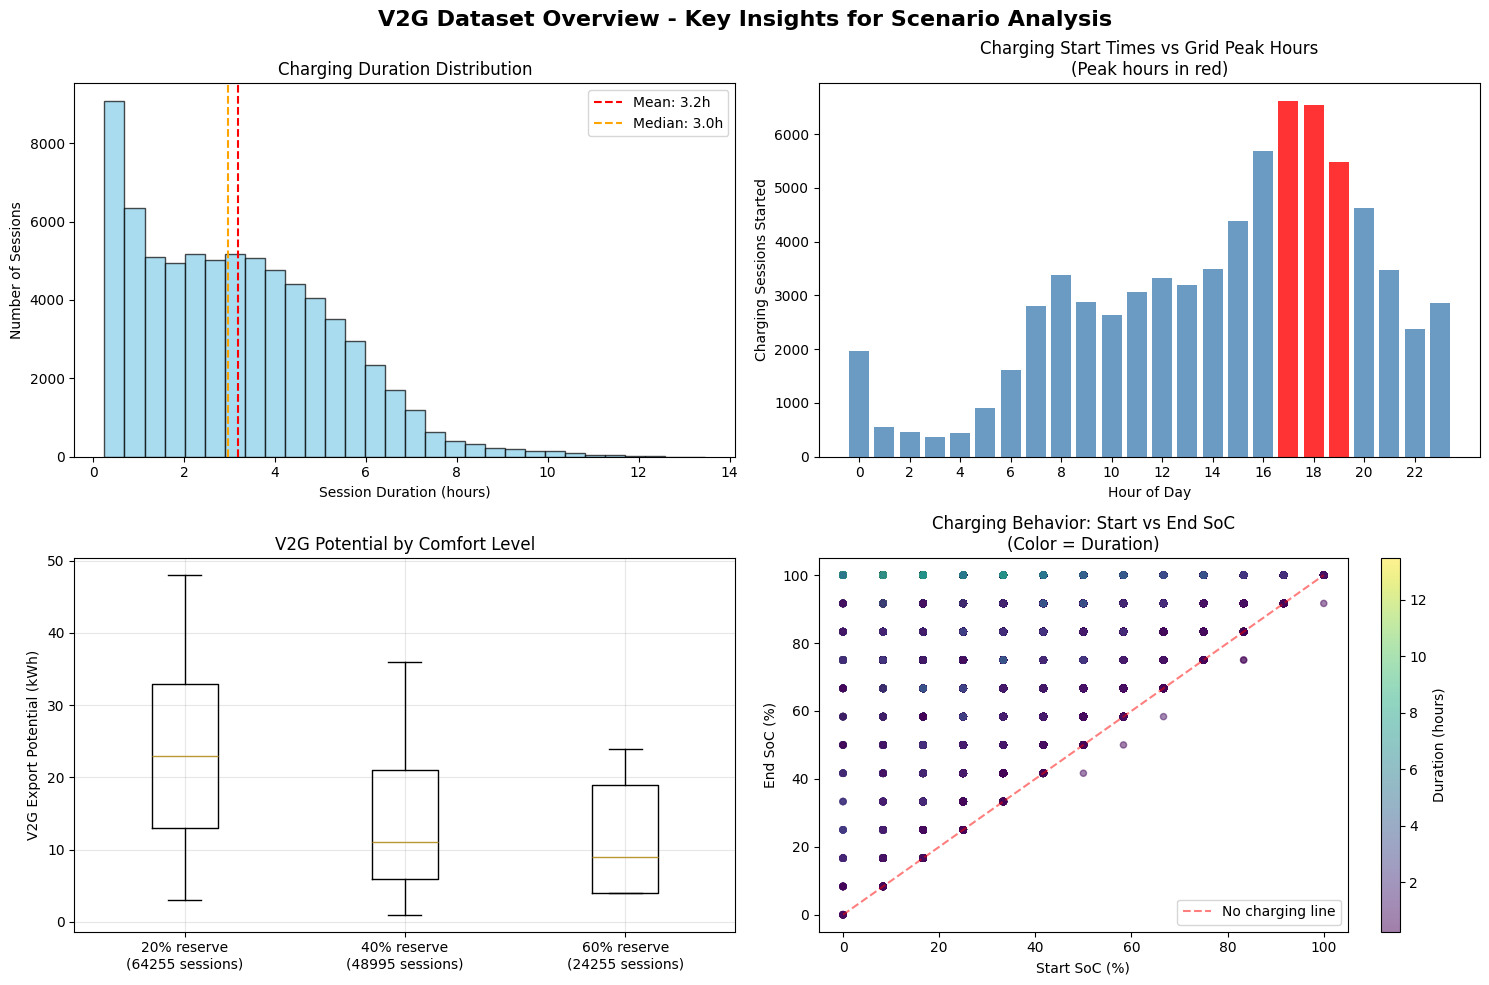

✅ EDA plots generated successfully


In [18]:
# Create focused summary plots for dissertation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('V2G Dataset Overview - Key Insights for Scenario Analysis', fontsize=16, fontweight='bold')

# Plot 1: Charging duration distribution
ax1 = axes[0, 0]
ax1.hist(df['duration_hours'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(df['duration_hours'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["duration_hours"].mean():.1f}h')
ax1.axvline(df['duration_hours'].median(), color='orange', linestyle='--',
           label=f'Median: {df["duration_hours"].median():.1f}h')
ax1.set_xlabel('Session Duration (hours)')
ax1.set_ylabel('Number of Sessions')
ax1.set_title('Charging Duration Distribution')
ax1.legend()

# Plot 2: Hourly charging patterns (grid alignment)
ax2 = axes[0, 1]
hourly_counts = df.groupby('start_hour').size()
peak_hours = [17, 18, 19]  # Typical evening peak
colors = ['red' if h in peak_hours else 'steelblue' for h in hourly_counts.index]
bars = ax2.bar(hourly_counts.index, hourly_counts.values, color=colors, alpha=0.8)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Charging Sessions Started')
ax2.set_title('Charging Start Times vs Grid Peak Hours\n(Peak hours in red)')
ax2.set_xticks(range(0, 24, 2))

# Plot 3: V2G potential at different reserve levels
ax3 = axes[1, 0]
reserve_data = []
reserve_labels = []
for reserve in comfort_reserves:
    col = f'v2g_kwh_reserve_{reserve}pc'
    if col in df.columns:
        eligible_sessions = df[df[col] > 0]
        reserve_data.append(eligible_sessions[col])
        reserve_labels.append(f'{reserve}% reserve\n({len(eligible_sessions)} sessions)')

ax3.boxplot(reserve_data, labels=reserve_labels)
ax3.set_ylabel('V2G Export Potential (kWh)')
ax3.set_title('V2G Potential by Comfort Level')
ax3.grid(True, alpha=0.3)

# Plot 4: SoC patterns (start vs end)
ax4 = axes[1, 1]
scatter = ax4.scatter(df['start_soc'], df['end_soc'], alpha=0.5, s=20, c=df['duration_hours'],
                     cmap='viridis')
ax4.plot([0, 100], [0, 100], 'r--', alpha=0.5, label='No charging line')
ax4.set_xlabel('Start SoC (%)')
ax4.set_ylabel('End SoC (%)')
ax4.set_title('Charging Behavior: Start vs End SoC\n(Color = Duration)')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Duration (hours)')
ax4.legend()

plt.tight_layout()
plt.show()

print("✅ EDA plots generated successfully")

# CELL 8: CREATE HOURLY TIME SERIES FOR SCENARIOS


In [19]:
print("🕐 Creating hourly availability time series...")

# Create complete hourly timeline
start_date = df['start_time'].min().floor('H')
end_date = df['end_time'].max().ceil('H')
hourly_timeline = pd.date_range(start_date, end_date, freq='H')

print(f"📅 Timeline: {start_date} to {end_date}")
print(f"📊 Total hours: {len(hourly_timeline):,}")

# Build hourly dataset
hourly_data = []

for timestamp in hourly_timeline:
    # Find sessions active during this hour
    active_sessions = df[
        (df['start_time'] <= timestamp) &
        (df['end_time'] > timestamp)
    ]

    # Calculate hourly metrics
    hour_metrics = {
        'timestamp': timestamp,
        'hour_of_day': timestamp.hour,
        'weekday': timestamp.weekday(),
        'is_weekend': timestamp.weekday() >= 5,
        'active_sessions': len(active_sessions),
        'total_v2g_40pc': active_sessions['v2g_kwh_reserve_40pc'].sum() if len(active_sessions) > 0 else 0,
        'avg_session_duration_remaining': active_sessions['duration_hours'].mean() if len(active_sessions) > 0 else 0
    }

    hourly_data.append(hour_metrics)

# Convert to DataFrame
hourly_df = pd.DataFrame(hourly_data)

# Summary stats
peak_sessions = hourly_df['active_sessions'].max()
peak_timestamp = hourly_df.loc[hourly_df['active_sessions'].idxmax(), 'timestamp']
peak_v2g = hourly_df['total_v2g_40pc'].max()

print(f"✅ Hourly dataset created: {len(hourly_df):,} hourly records")
print(f"📈 Peak concurrent sessions: {peak_sessions} at {peak_timestamp}")
print(f"⚡ Peak V2G potential: {peak_v2g:.1f} kWh at peak hour")


🕐 Creating hourly availability time series...
📅 Timeline: 2013-12-20 10:00:00 to 2015-11-29 20:00:00
📊 Total hours: 17,027
✅ Hourly dataset created: 17,027 hourly records
📈 Peak concurrent sessions: 65 at 2015-01-28 22:00:00
⚡ Peak V2G potential: 506.0 kWh at peak hour


In [20]:
# Check the timeline makes sense
timeline_days = (df['start_time'].max() - df['start_time'].min()).days
expected_hours = timeline_days * 24
print(f"📅 Data spans: {timeline_days} days")
print(f"📊 Expected hours: {expected_hours}")
print(f"📈 Actual hourly records: {len(hourly_df)}")
print(f"🎯 Average sessions per hour: {len(df) / len(hourly_df):.1f}")

📅 Data spans: 709 days
📊 Expected hours: 17016
📈 Actual hourly records: 17027
🎯 Average sessions per hour: 4.3


# CELL 9 : Real Pricing Data

In [21]:
# ===== REAL PRICE DATA: Retail Baseline + Imbalance Sensitivity =====
import os, requests, pandas as pd, numpy as np
from datetime import timedelta

# --- helper: Agile (import/export) → DOW×hour profile in £/kWh ---
def fetch_agile_profile(region_code="C", kind="export", start_date=None, end_date=None) -> pd.DataFrame:
    """
    Fetch Octopus Agile data (import or Agile Outgoing export) for a window.
    Returns DOW×hour mean profile with columns: day_of_week, hour, price_gbp_per_kwh
    """
    url = f"https://agilerates.uk/api/agile_rates_region_{region_code}.json"
    r = requests.get(url, timeout=30); r.raise_for_status()
    data = r.json()
    rates = pd.json_normalize(data["rates"])

    rate_field = "agileOutgoingRate.result.rate" if kind == "export" else "agileRate.result.rate"
    if rate_field not in rates.columns:
        raise KeyError(f"Field '{rate_field}' missing for kind='{kind}'. Available: {list(rates.columns)}")

    df = rates[["deliveryStart", rate_field]].rename(columns={
        "deliveryStart": "timestamp_utc",
        rate_field: "price_p_per_kwh"
    })
    df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], utc=True, errors="coerce")
    df["timestamp_uk"]  = df["timestamp_utc"].dt.tz_convert("Europe/London")

    # enforce inclusive window (Europe/London)
    if start_date and end_date:
        t0 = pd.Timestamp(start_date, tz="Europe/London")
        t1 = pd.Timestamp(end_date,   tz="Europe/London") + pd.Timedelta(days=1)
        df = df[(df["timestamp_uk"] >= t0) & (df["timestamp_uk"] < t1)]

    if df.empty:
        raise RuntimeError(f"No Agile data found for kind='{kind}' in {start_date}→{end_date} (region {region_code}).")

    # ensure numeric and convert to £/kWh
    df["price_p_per_kwh"] = pd.to_numeric(df["price_p_per_kwh"], errors="coerce")
    df["price_gbp_per_kwh"] = df["price_p_per_kwh"] / 100.0

    df["day_of_week"] = df["timestamp_uk"].dt.dayofweek
    df["hour"]        = df["timestamp_uk"].dt.hour

    prof = (df.groupby(["day_of_week","hour"])["price_gbp_per_kwh"]
              .mean().reset_index())
    return prof

# --- main: build baseline (retail) and sensitivity (imbalance) ---
def analyze_pricing_landscape(
    region_code: str = "C",
    start_date: str = None,      # e.g. "2024-09-13"
    end_date: str = None,        # e.g. "2025-09-12"
    round_trip_eff: float = 0.90,        # battery round-trip eff
    export_inverter_eff: float = 0.96,   # one-way export inverter eff
    degradation_gbp_per_kwh: float = 0.04
) -> dict:
    """
    Returns a dict with:
      - 'baseline': retail net value profile (Agile Outgoing export vs Agile import)
      - 'sensitivity_imbalance': net value using imbalance as export (if available)
      - plus the component profiles and summary stats
    """
    # default to last 12 months ending yesterday (Europe/London)
    if not start_date or not end_date:
        end_date = (pd.Timestamp.now(tz="Europe/London") - pd.Timedelta(days=1)).strftime("%Y-%m-%d")
        start_date = (pd.Timestamp(end_date) - pd.Timedelta(days=365)).strftime("%Y-%m-%d")

    print("\n5️⃣ PRICE ANALYSIS: Retail Baseline + Imbalance Sensitivity")
    print("—" * 60)
    print(f"📅 Window: {start_date} → {end_date}  (Europe/London)")

    # RETAIL EXPORT (Agile Outgoing)
    export_prof = fetch_agile_profile(region_code, "export", start_date, end_date)\
                    .rename(columns={"price_gbp_per_kwh":"export_price_gbp_per_kwh"})
    e_stats = export_prof["export_price_gbp_per_kwh"].describe()
    print(f"📤 Retail export (Agile Outgoing): mean £/kWh={e_stats['mean']:.3f}  "
          f"min={e_stats['min']:.3f}  max={e_stats['max']:.3f}")

    # RETAIL IMPORT (Agile)
    import_prof = fetch_agile_profile(region_code, "import", start_date, end_date)\
                    .rename(columns={"price_gbp_per_kwh":"import_price_gbp_per_kwh"})
    i_stats = import_prof["import_price_gbp_per_kwh"].describe()
    print(f"📥 Retail import (Agile):        mean £/kWh={i_stats['mean']:.3f}  "
          f"min={i_stats['min']:.3f}  max={i_stats['max']:.3f}")

    # MERGE & BASELINE NET VALUE (per exported kWh)
    merged = export_prof.merge(import_prof, on=["day_of_week","hour"], how="inner")
    eta_rt  = float(np.clip(round_trip_eff, 0.01, 1.0))
    eta_out = float(np.clip(export_inverter_eff, 0.50, 1.0))

    def net_row(r):
        revenue = eta_out * r["export_price_gbp_per_kwh"]
        buy_kwh = 1.0 / eta_rt
        cost    = buy_kwh * r["import_price_gbp_per_kwh"]
        return revenue - cost - degradation_gbp_per_kwh

    merged["net_value_gbp_per_export_kwh"] = merged.apply(net_row, axis=1)
    nv = merged["net_value_gbp_per_export_kwh"].describe()
    pos_hours = int((merged["net_value_gbp_per_export_kwh"] > 0).sum())
    print(f"💷 Baseline net after losses & degradation: mean={nv['mean']:.3f}  "
          f"min={nv['min']:.3f}  max={nv['max']:.3f}  >0 hours: {pos_hours}/168")

    results = {
        "window": {"start": start_date, "end": end_date},
        "retail_export": {
            "source": "Octopus Agile Outgoing",
            "mean_price": float(e_stats["mean"]),
            "profile": export_prof
        },
        "retail_import": {
            "source": "Octopus Agile",
            "mean_price": float(i_stats["mean"]),
            "profile": import_prof
        },
        "baseline": {  # retail baseline net
            "round_trip_eff": eta_rt,
            "export_inverter_eff": eta_out,
            "degradation_gbp_per_kwh": float(degradation_gbp_per_kwh),
            "mean_net": float(nv["mean"]),
            "positive_hours": pos_hours,
            "profile": merged[["day_of_week","hour","net_value_gbp_per_export_kwh"]]
        }
    }

    # IMBALANCE SENSITIVITY (typo-safe + key check)
    print("⚡ Imbalance sensitivity:")
    bmrs_key = os.getenv("BMRS_API_KEY", "").strip()
    # Accept either correct or misspelled class name
    mgr = globals().get("ImbalancePricingManager") or globals().get("ImbalancedPricingManager")
    imbalance_prof = None
    if bmrs_key and bmrs_key.upper() not in {"YOUR_BMRS_KEY","REPLACE_ME"} and mgr is not None:
        try:
            imb = mgr.fetch_imbalance_prices(
                api_key=bmrs_key, start_date=start_date, end_date=end_date, price_choice="mid"
            )
            # Ensure 7×24 grid; compute DOW×hour mean if raw is many days
            if {"day_of_week","hour","imbalance_price_gbp_per_kwh"}.issubset(imb.columns):
                imbalance_prof = (imb.groupby(["day_of_week","hour"], as_index=False)
                                    .agg(imbalance_price_gbp_per_kwh=("imbalance_price_gbp_per_kwh","mean")))
                m = float(imbalance_prof["imbalance_price_gbp_per_kwh"].mean())
                print(f"   ✅ Imbalance DOW×hour profile ready; mean £/kWh≈{m:.3f}")
            else:
                print("   ⚠️ Imbalance data shape unexpected; skipping sensitivity.")
        except Exception as e:
            print(f"   ⚠️ Imbalance fetch failed: {e} (sensitivity skipped)")
    else:
        print("   ℹ️ No BMRS key or manager not defined; skipping sensitivity.")

    if imbalance_prof is not None:
        sens = (imbalance_prof
                  .merge(import_prof, on=["day_of_week","hour"], how="left")
                  .rename(columns={"imbalance_price_gbp_per_kwh":"export_price_gbp_per_kwh"}))
        sens["net_value_gbp_per_export_kwh"] = sens.apply(net_row, axis=1)
        snv = sens["net_value_gbp_per_export_kwh"].describe()
        spos = int((sens["net_value_gbp_per_export_kwh"] > 0).sum())
        print(f"   💡 Sensitivity (imbalance export): mean={snv['mean']:.3f}  "
              f"min={snv['min']:.3f}  max={snv['max']:.3f}  >0 hours: {spos}/168")

        results["sensitivity_imbalance"] = {
            "mean_net": float(snv["mean"]),
            "positive_hours": spos,
            "profile": sens[["day_of_week","hour","net_value_gbp_per_export_kwh"]]
        }
    else:
        results["sensitivity_imbalance"] = None

    # Quick summary for dashboards
    results["summary"] = {
        "baseline_mean_net": results["baseline"]["mean_net"],
        "baseline_pos_hours": results["baseline"]["positive_hours"],
        "retail_export_mean": results["retail_export"]["mean_price"],
        "retail_import_mean": results["retail_import"]["mean_price"],
        "sensitivity_mean_net": (results["sensitivity_imbalance"]["mean_net"]
                                 if results["sensitivity_imbalance"] else None)
    }
    return results


# CELL 10: Price hourly V2G with retail baseline


In [22]:
import requests
import pandas as pd
from datetime import datetime, timedelta

class OctopusAgileOnly:
    """
    Fetch Octopus Agile half-hourly retail prices (inc. VAT) from the public API.
    - Returns: timestamp_utc, agile_price_gbp_per_kwh (+ convenience gbp_per_mwh)
    - Fully paginated; no fallbacks/synthetic data.
    """

    def __init__(self):
        self.agile = None
        self.summary = {}

    def get_agile(self, start_date, end_date,
                  product_code="AGILE-18-02-21",
                  tariff_code="E-1R-AGILE-18-02-21-C",
                  page_size=2500):
        """
        Pull Agile 'standard-unit-rates' between [start_date, end_date].
        If your region uses a different tariff suffix, pass the right tariff_code.
        """
        base = (
            f"https://api.octopus.energy/v1/products/{product_code}/"
            f"electricity-tariffs/{tariff_code}/standard-unit-rates/"
        )
        params = {
            "period_from": pd.Timestamp(start_date).isoformat(),
            "period_to":   pd.Timestamp(end_date).isoformat(),
            "page_size":   page_size,
        }

        rows, url = [], base
        while True:
            r = requests.get(url, params=params, timeout=60)
            r.raise_for_status()
            js = r.json()
            for res in js.get("results", []):
                ts = pd.to_datetime(res["valid_from"], utc=True)
                price_gbp_per_kwh = float(res["value_inc_vat"]) / 100.0  # p/kWh -> £/kWh
                rows.append({
                    "timestamp_utc": ts,
                    "agile_price_gbp_per_kwh": price_gbp_per_kwh,
                })
            next_url = js.get("next")
            if not next_url:
                break
            url, params = next_url, None  # 'next' is a full URL

        df = (pd.DataFrame(rows)
              .drop_duplicates("timestamp_utc")
              .sort_values("timestamp_utc")
              .reset_index(drop=True))

        # clip strictly to the requested window
        mask = (df["timestamp_utc"] >= pd.Timestamp(start_date, tz="UTC")) & \
               (df["timestamp_utc"] <= pd.Timestamp(end_date, tz="UTC"))
        df = df.loc[mask].reset_index(drop=True)

        # convenience: £/MWh
        df["agile_price_gbp_per_mwh"] = df["agile_price_gbp_per_kwh"] * 1000.0

        self.agile = df
        print(f"✅ Agile rows: {len(df)} | Range: {df['timestamp_utc'].min()} → {df['timestamp_utc'].max()}")
        return df

    def summarize(self):
        """Quick stats from the fetched Agile series."""
        if self.agile is None or self.agile.empty:
            raise ValueError("Fetch Agile data first with get_agile().")
        r = self.agile.copy()
        r["hour"] = r["timestamp_utc"].dt.hour
        peak_hours = [17, 18, 19, 20]
        off_peak = [1, 2, 3, 4, 5]

        s = {
            "avg_gbp_per_kwh": r["agile_price_gbp_per_kwh"].mean(),
            "std_gbp_per_kwh": r["agile_price_gbp_per_kwh"].std(),
            "min_gbp_per_kwh": r["agile_price_gbp_per_kwh"].min(),
            "max_gbp_per_kwh": r["agile_price_gbp_per_kwh"].max(),
            "peak_avg": r[r["hour"].isin(peak_hours)]["agile_price_gbp_per_kwh"].mean(),
            "offpeak_avg": r[r["hour"].isin(off_peak)]["agile_price_gbp_per_kwh"].mean(),
        }
        s["spread"] = s["peak_avg"] - s["offpeak_avg"]
        self.summary = s
        print(
            f"📊 Agile avg £/kWh: {s['avg_gbp_per_kwh']:.3f} | "
            f"peak {s['peak_avg']:.3f} | off-peak {s['offpeak_avg']:.3f} | "
            f"spread {s['spread']:.3f} | vol (std) {s['std_gbp_per_kwh']:.3f}"
        )
        return s


In [23]:
octo = OctopusAgileOnly()
octo.get_agile("2025-06-15", "2025-09-13",
               product_code="AGILE-18-02-21",
               tariff_code="E-1R-AGILE-18-02-21-C")
summary = octo.summarize()
df = octo.agile  # your half-hourly series


✅ Agile rows: 4318 | Range: 2025-06-15 00:00:00+00:00 → 2025-09-12 22:30:00+00:00
📊 Agile avg £/kWh: 0.169 | peak 0.238 | off-peak 0.143 | spread 0.095 | vol (std) 0.074


# CELL 11 — Agile price EDA (distributions, tails, seasonality)

📈 Agile price EDA
————————————————————————————————————————————————————————————
count    4318.000000
mean        0.168514
std         0.073874
min        -0.049350
25%         0.144900
50%         0.165112
75%         0.199500
max         0.349965
p5=0.013, p95=0.305, negative-price slots=102


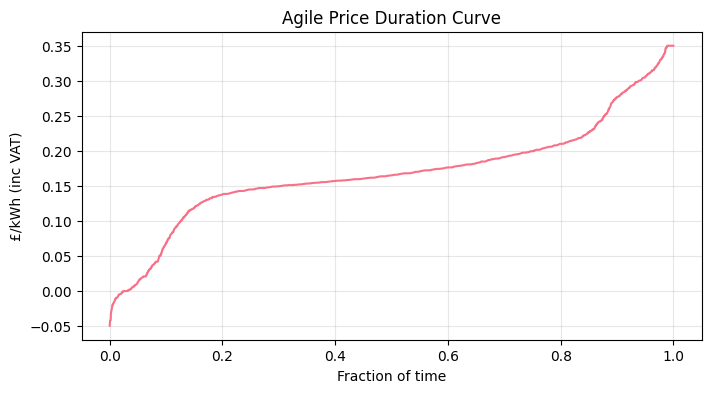

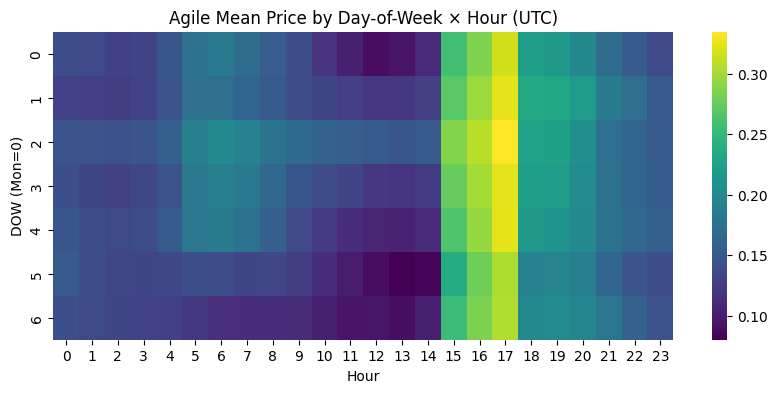

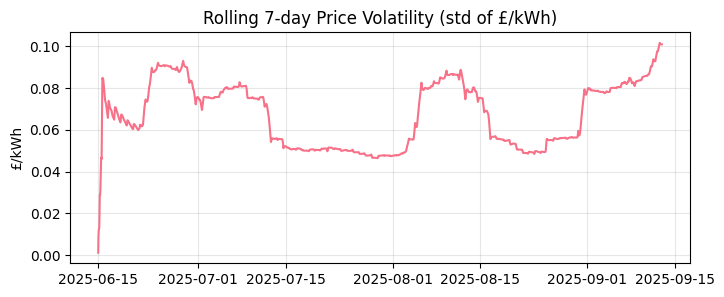

In [24]:
print("📈 Agile price EDA")

agile = octo.agile.copy()
agile["dow"]  = agile["timestamp_utc"].dt.dayofweek
agile["hour"] = agile["timestamp_utc"].dt.hour
agile["date"] = agile["timestamp_utc"].dt.date

# Basic stats
print("—"*60)
print(agile["agile_price_gbp_per_kwh"].describe().to_string())
pct05 = agile["agile_price_gbp_per_kwh"].quantile(0.05)
pct95 = agile["agile_price_gbp_per_kwh"].quantile(0.95)
neg_ct = (agile["agile_price_gbp_per_kwh"] < 0).sum()
print(f"p5={pct05:.3f}, p95={pct95:.3f}, negative-price slots={neg_ct}")

# Price duration curve (sorted)
plt.figure(figsize=(8,4))
plt.plot(
    np.arange(len(agile))/len(agile),
    np.sort(agile["agile_price_gbp_per_kwh"].values)
)
plt.xlabel("Fraction of time"); plt.ylabel("£/kWh (inc VAT)")
plt.title("Agile Price Duration Curve")
plt.grid(alpha=0.3); plt.show()

# DOW×Hour heatmap (mean price)
pivot = agile.pivot_table(index="dow", columns="hour", values="agile_price_gbp_per_kwh", aggfunc="mean")
plt.figure(figsize=(10,4))
sns.heatmap(pivot, annot=False, cmap="viridis")
plt.title("Agile Mean Price by Day-of-Week × Hour (UTC)"); plt.xlabel("Hour"); plt.ylabel("DOW (Mon=0)")
plt.show()

# Volatility: rolling 7-day std (hourly proxy)
agile_hourly = (agile.set_index("timestamp_utc")
                     .resample("1H")["agile_price_gbp_per_kwh"].mean())  # avg of two half-hours
rolling_std = agile_hourly.rolling("7D").std()
plt.figure(figsize=(8,3))
plt.plot(rolling_std.index, rolling_std.values)
plt.title("Rolling 7-day Price Volatility (std of £/kWh)"); plt.ylabel("£/kWh"); plt.xlabel("")
plt.grid(alpha=0.3); plt.show()


# CELL 12 — Scenario Analysis

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class V2GScenarioAnalyzer:
    """
    Integrated V2G Scenario Analysis Framework

    Takes your cleaned data and runs it through coherent scenarios that combine:
    - Participation rates (how many EVs join V2G)
    - Market access (retail vs wholesale vs stacked revenues)
    - User comfort levels (battery reserves)
    - Behavioral patterns (charging optimization)
    """

    def __init__(self, df, hourly_df, battery_capacity_kwh=60.0):
        """
        Initialize with your existing clean datasets

        Args:
            df: Your main session dataframe (73k+ records)
            hourly_df: Your hourly availability dataframe
            battery_capacity_kwh: Battery size for calculations
        """
        self.df = df.copy()
        self.hourly_df = hourly_df.copy()
        self.battery_capacity = battery_capacity_kwh
        self.scenario_results = {}

        # Validate required columns (now includes user_segment)
        required_cols = ['vehicle_id', 'start_time', 'end_time', 'start_soc', 'end_soc',
                         'duration_hours', 'start_hour', 'is_weekend', 'user_segment']
        missing = [col for col in required_cols if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        print(f"✅ Initialized V2G Scenario Analyzer")
        print(f"📊 Data: {len(self.df):,} sessions, {len(self.hourly_df):,} hourly records")
        print(f"🔋 Battery capacity: {battery_capacity_kwh} kWh")

    def define_scenario_parameters(self):
        """
        Define the integrated scenario framework - each scenario combines ALL dimensions
        """
        scenarios = {
            'Conservative_Current': {
                'name': 'Conservative (Current State)',
                'description': 'Limited V2G adoption with retail pricing only',
                'participation_rate': 0.20,       # 20% of EV owners join V2G
                'comfort_reserve_pct': 50,        # High comfort - 50% battery reserve
                'market_access': 'retail_only',   # Octopus Agile export only
                'behavioral_optimization': 0.3,   # 30% optimize charging timing
                'grid_response_speed': 'slow',    # 4-hour response time
                'revenue_streams': ['energy_export'],
                'color': '#ff6b6b'  # Red
            },

            'Progressive_Market': {
                'name': 'Progressive (Market Access)',
                'description': 'Moderate adoption with revenue stacking enabled',
                'participation_rate': 0.55,       # 55% join V2G programs
                'comfort_reserve_pct': 40,        # Medium comfort - 40% reserve
                'market_access': 'revenue_stacking', # Multiple revenue streams
                'behavioral_optimization': 0.65,  # 65% optimize behavior
                'grid_response_speed': 'medium',  # 2-hour response
                'revenue_streams': ['energy_export', 'frequency_response', 'capacity_market'],
                'color': '#4ecdc4'  # Teal
            },

            'Transformative_Integration': {
                'name': 'Transformative (Full Integration)',
                'description': 'High adoption with wholesale market access',
                'participation_rate': 0.80,       # 80% participate
                'comfort_reserve_pct': 20,        # Low comfort - 20% reserve
                'market_access': 'wholesale_plus',# Direct wholesale + services
                'behavioral_optimization': 0.85,  # 85% optimize fully
                'grid_response_speed': 'fast',    # 30-minute response
                'revenue_streams': ['energy_export', 'frequency_response', 'capacity_market', 'balancing_services'],
                'color': '#45b7d1'  # Blue
            },

            'Sensitivity_High': {
                'name': 'Sensitivity (Optimistic)',
                'description': 'Best-case scenario for sensitivity analysis',
                'participation_rate': 0.90,       # 90% participate
                'comfort_reserve_pct': 15,        # Very low reserve
                'market_access': 'future_optimal',# Perfect market access
                'behavioral_optimization': 0.95,  # Near-perfect optimization
                'grid_response_speed': 'instant', # Real-time response
                'revenue_streams': ['energy_export', 'frequency_response', 'capacity_market', 'balancing_services', 'reactive_power'],
                'color': '#96ceb4'  # Green
            }
        }

        self.scenarios = scenarios
        return scenarios

    def calculate_data_driven_multipliers(self):
        """
        Calculate participation multipliers from observed behavioral patterns
        """
        multipliers = {}

        for segment in self.df['user_segment'].unique():
            segment_data = self.df[self.df['user_segment'] == segment].copy()

            if len(segment_data) == 0:
                multipliers[segment] = 1.0
                continue

            # 1) CONSISTENCY score: lower variance of start_hour & duration -> higher score
            vehicle_consistency = []
            for vehicle in segment_data['vehicle_id'].unique():
                vehicle_sessions = segment_data[segment_data['vehicle_id'] == vehicle]
                if len(vehicle_sessions) > 1:
                    hour_std = vehicle_sessions['start_hour'].std()
                    duration_std = vehicle_sessions['duration_hours'].std()
                    consistency = 1 / (1 + (hour_std or 0)/24 + (duration_std or 0)/12)
                    vehicle_consistency.append(consistency)
            avg_consistency = np.mean(vehicle_consistency) if vehicle_consistency else 0.5

            # 2) FLEXIBILITY score: more distinct start hours -> higher score
            hour_variety = segment_data.groupby('vehicle_id')['start_hour'].nunique().mean()
            flexibility = min((hour_variety or 0) / 12, 1.0)

            # 3) GRID-ALIGNMENT: avoid 16–20h & use 22–05h -> higher score
            peak_hours = [16, 17, 18, 19, 20]
            peak_avoidance = 1 - segment_data['start_hour'].isin(peak_hours).mean()
            off_peak_hours = [22, 23, 0, 1, 2, 3, 4, 5]
            off_peak_usage = segment_data['start_hour'].isin(off_peak_hours).mean()
            grid_alignment = (peak_avoidance + off_peak_usage) / 2

            # 4) Combine
            raw_score = (avg_consistency * 0.4 +
                         flexibility * 0.3 +
                         grid_alignment * 0.3)
            multiplier = 0.7 + (raw_score * 0.6)  # 0.7–1.3 range
            multipliers[segment] = round(multiplier, 2)

        return multipliers

    def calculate_participation_by_segment(self, scenario_key):
        """
        Calculate realistic participation rates by user segment
        """
        scenario = self.scenarios[scenario_key]
        base_participation = scenario['participation_rate']

        # Segment-specific multipliers from data
        segment_multipliers = self.calculate_data_driven_multipliers()
        print(f"Data-driven multipliers: {segment_multipliers}")

        participating_sessions = []

        for segment in self.df['user_segment'].unique():
            segment_data = self.df[self.df['user_segment'] == segment].copy()
            unique_vehicles = segment_data['vehicle_id'].unique()

            participation_rate = base_participation * segment_multipliers.get(segment, 1.0)
            participation_rate = min(participation_rate, 0.95)  # Cap at 95%

            n_participating_vehicles = int(len(unique_vehicles) * participation_rate)
            n_participating_vehicles = min(n_participating_vehicles, len(unique_vehicles))

            if n_participating_vehicles > 0:
                # Safe seed for numeric or string segments
                seed = 42 + (hash(str(segment)) % 10_000)
                rng = np.random.default_rng(seed)
                participating_vehicles = rng.choice(unique_vehicles, n_participating_vehicles, replace=False)

                # All sessions for participating vehicles
                participants = segment_data[segment_data['vehicle_id'].isin(participating_vehicles)]
                participating_sessions.append(participants)

        if participating_sessions:
            return pd.concat(participating_sessions, ignore_index=True)
        else:
            return pd.DataFrame(columns=self.df.columns)

    def calculate_v2g_capacity(self, participating_sessions, comfort_reserve_pct):
        """
        Calculate available V2G capacity based on comfort levels
        """
        reserve_col = f'v2g_kwh_reserve_{comfort_reserve_pct}pc'
        if reserve_col not in participating_sessions.columns:
            participating_sessions[reserve_col] = np.maximum(
                0,
                (participating_sessions['start_soc'] - comfort_reserve_pct) * self.battery_capacity / 100
            )
        return float(participating_sessions[reserve_col].sum())

    # ---------- NEW: segment-weighted utilisation from hourly_df ----------
    def _segment_utilisation(self, comfort_reserve_frac=0.40, threshold_min=30):
        """
        Compute utilisation per user_segment from hourly_df:
          - eligible = plugged & SoC >= comfort_reserve_frac
          - session eligible if eligible_minutes >= threshold_min
          - utilisation (time-weighted) = eligible_minutes_in_eligible_sessions / total_plugged_minutes
        Returns dict {segment_value: utilisation_float}. Falls back to {} if columns missing.
        """
        h = self.hourly_df.copy()
        # Find columns (best effort)
        soc_col = next((c for c in ['soc_frac','soc','SoC','SOC','state_of_charge','soc_percent','soc_pct'] if c in h.columns), None)
        plug_col = next((c for c in ['is_plugged','plugged','connected','is_connected','plug_status'] if c in h.columns), None)
        sess_col = next((c for c in ['session_id','session','charge_session_id'] if c in h.columns), None)
        mins_col = 'connected_minutes' if 'connected_minutes' in h.columns else None
        if soc_col is None or plug_col is None or sess_col is None:
            return {}

        # Normalise SoC to [0,1]
        soc = pd.to_numeric(h[soc_col], errors='coerce')
        if soc.max(skipna=True) and soc.max() > 1.05:
            soc = soc / 100.0
        h['_soc'] = soc.clip(0, 1)
        h['_plug'] = h[plug_col].astype(bool)
        h['_mins'] = pd.to_numeric(h[mins_col], errors='coerce').fillna(60.0) if mins_col else 60.0

        # Attach segment per vehicle
        seg_map = self.df[['vehicle_id', 'user_segment']].drop_duplicates()
        h = h.merge(seg_map, on='vehicle_id', how='left')

        out = {}
        for seg, g in h.groupby('user_segment', dropna=False):
            if g.empty:
                continue
            g = g.copy()
            g['_eligible'] = g['_plug'] & (g['_soc'] >= float(comfort_reserve_frac))
            g['_elig_mins'] = g['_mins'].where(g['_eligible'], 0.0)

            s = g.groupby(sess_col).agg(plugged_mins=('_mins', 'sum'),
                                        eligible_mins=('_elig_mins', 'sum'))
            plugged_minutes = float(s['plugged_mins'].sum())
            if plugged_minutes == 0:
                out[seg] = 0.0
                continue
            mask = (s['plugged_mins'] > 0) & (s['eligible_mins'] >= float(threshold_min))
            eligible_minutes_thr = float(s.loc[mask, 'eligible_mins'].sum())
            out[seg] = eligible_minutes_thr / plugged_minutes
        return out

    def calculate_data_driven_export_potential(self, participating_sessions, comfort_reserve_pct):
        """
        Calculate realistic annual export per vehicle from actual data:
          - avg energy per session (from session df)
          - annualised session frequency per vehicle (exposure-adjusted over multi-year panel)
          - segment-weighted utilisation at 30 min from hourly_df (fallback to 0.30)
          - round-trip efficiency = 0.80
        """
        reserve_col = f'v2g_kwh_reserve_{comfort_reserve_pct}pc'

        # Average available energy per session from real data
        avg_export_per_session = float(participating_sessions[reserve_col].mean()) if len(participating_sessions) else 0.0

        # Sessions per vehicle per year (exposure-adjusted over observation window)
        n_vehicles = participating_sessions['vehicle_id'].nunique()
        if n_vehicles == 0 or avg_export_per_session == 0.0:
            return 0.0

        ps = participating_sessions.copy()
        ps['start_time'] = pd.to_datetime(ps['start_time'])
        ps['end_time'] = pd.to_datetime(ps['end_time'])

        obs = ps.groupby('vehicle_id').agg(
            first_seen=('start_time', 'min'),
            last_seen=('end_time', 'max'),
            sessions=('vehicle_id', 'size')
        )
        obs['days_observed'] = (obs['last_seen'] - obs['first_seen']).dt.total_seconds() / 86400.0
        obs['days_observed'] = obs['days_observed'].clip(lower=1.0)
        # Cap annualisation to avoid extreme inflation for very short windows
        obs['annual_factor'] = (365.25 / obs['days_observed']).clip(upper=2.0)
        obs['sessions_per_year'] = obs['sessions'] * obs['annual_factor']
        sessions_per_vehicle_per_year = float(obs['sessions_per_year'].mean())

        # Segment-weighted utilisation at 30 min for this comfort reserve
        seg_util = self._segment_utilisation(comfort_reserve_frac=comfort_reserve_pct/100.0, threshold_min=30)
        if seg_util:
            mix = participating_sessions[['vehicle_id']].merge(
                self.df[['vehicle_id', 'user_segment']].drop_duplicates(), on='vehicle_id', how='left'
            )
            weights = mix['user_segment'].value_counts(normalize=True).to_dict()
            utilisation = float(sum(seg_util.get(seg, 0.0) * w for seg, w in weights.items()))
        else:
            utilisation = 0.30  # fallback baseline (typical UK plug-in availability)

        # Round-trip efficiency (literature-defensible)
        round_trip_eff = 0.87

        annual_export_per_vehicle = avg_export_per_session * sessions_per_vehicle_per_year * utilisation * round_trip_eff
        return float(annual_export_per_vehicle)

    def calculate_revenue_streams(self, scenario_key, participating_sessions, total_capacity_kwh):
        """
        Calculate revenue using DATA-DRIVEN calculations where possible
        """
        scenario = self.scenarios[scenario_key]
        revenue_streams = scenario['revenue_streams']
        n_vehicles = len(participating_sessions['vehicle_id'].unique())

        revenues = {}

        # Base energy export revenue - DATA DRIVEN
        if 'energy_export' in revenue_streams:
            annual_export_kwh_per_vehicle = self.calculate_data_driven_export_potential(
                participating_sessions, scenario['comfort_reserve_pct']
            )
            # Market pricing - clearly documented assumption
            avg_export_price = 0.15  # £0.15/kWh - Octopus Agile typical (ASSUMPTION - cite source)
            total_export_revenue = n_vehicles * annual_export_kwh_per_vehicle * avg_export_price
            revenues['energy_export'] = float(total_export_revenue)

        # Frequency response - MARKET RATE ASSUMPTIONS (document in dissertation)
        if 'frequency_response' in revenue_streams:
            freq_response_rate_per_mw_hour = 8  # £8/MW/hour - 2023 average (CITE: National Grid ESO)
            avg_power_per_vehicle_kw = 7        # 7kW typical V2G power (CITE: technical specs)
            total_power_mw = (n_vehicles * avg_power_per_vehicle_kw) / 1000
            utilization_hours_per_day = 2       # Average availability requirement (ASSUMPTION)
            freq_revenue = (total_power_mw * freq_response_rate_per_mw_hour *
                            utilization_hours_per_day * 365)
            revenues['frequency_response'] = float(freq_revenue)

        # Capacity market - UK MARKET RATES (document assumptions)
        if 'capacity_market' in revenue_streams:
            capacity_market_rate_per_kw_year = 63  # £63/kW/year - 2023 clearing price
            reliable_capacity_kw = n_vehicles * 5  # 5kW reliable per vehicle (ASSUMPTION)
            capacity_revenue = reliable_capacity_kw * capacity_market_rate_per_kw_year
            revenues['capacity_market'] = float(capacity_revenue)

        # Balancing services - BEHAVIORAL ASSUMPTIONS (document clearly)
        if 'balancing_services' in revenue_streams:
            balancing_rate_per_kwh = 2  # £2/kWh during stress events
            stress_events_per_year = 10  # Frequency of high-price events
            kwh_per_vehicle_per_event = 5  # Energy delivered per event
            balancing_revenue = (n_vehicles * kwh_per_vehicle_per_event *
                                 stress_events_per_year * balancing_rate_per_kwh)
            revenues['balancing_services'] = float(balancing_revenue)

        # Future revenue streams - SPECULATIVE (mark clearly as future potential)
        if 'reactive_power' in revenue_streams:
            reactive_power_rate_per_kw_year = 15  # £15/kW/year (SPECULATIVE)
            reactive_power_per_vehicle_kw = 3     # 3kW reactive power capability
            reactive_revenue = n_vehicles * reactive_power_per_vehicle_kw * reactive_power_rate_per_kw_year
            revenues['reactive_power'] = float(reactive_revenue)

        total_revenue = float(sum(revenues.values()))
        return revenues, total_revenue

    def calculate_grid_impact_metrics(self, participating_sessions, scenario_key):
        """
        Calculate grid impact metrics for each scenario
        """
        scenario = self.scenarios[scenario_key]

        # Peak hour analysis (4-8 PM weekdays)
        peak_hours = [16, 17, 18, 19, 20]
        weekday_sessions = participating_sessions[~participating_sessions['is_weekend']]
        peak_sessions = weekday_sessions[weekday_sessions['start_hour'].isin(peak_hours)]

        # Calculate grid support capacity during peak
        reserve_col = f"v2g_kwh_reserve_{scenario['comfort_reserve_pct']}pc"
        peak_capacity = peak_sessions[reserve_col].sum() if not peak_sessions.empty else 0
        peak_power_mw = peak_capacity / 4.0 / 1000  # 4-hour discharge, convert to MW

        # Grid response characteristics
        response_times = {'slow': 4, 'medium': 2, 'fast': 0.5, 'instant': 0.1}
        response_time = response_times.get(scenario['grid_response_speed'], 2)

        metrics = {
            'peak_capacity_kwh': float(peak_capacity),
            'peak_power_mw': float(peak_power_mw),
            'response_time_hours': float(response_time),
            'participating_vehicles': int(len(participating_sessions['vehicle_id'].unique())),
            'total_sessions': int(len(participating_sessions)),
            'avg_session_duration': float(participating_sessions['duration_hours'].mean()) if len(participating_sessions) else 0.0,
            'weekend_availability': float(len(participating_sessions[participating_sessions['is_weekend']]) / len(participating_sessions)) if len(participating_sessions) else 0.0
        }

        return metrics

    def run_single_scenario(self, scenario_key):
        """
        Run complete analysis for one scenario
        """
        print(f"\n🔄 Running {scenario_key}...")

        # Get participating sessions based on scenario parameters
        participating_sessions = self.calculate_participation_by_segment(scenario_key)
        scenario = self.scenarios[scenario_key]

        # Calculate V2G capacity
        total_capacity = self.calculate_v2g_capacity(
            participating_sessions,
            scenario['comfort_reserve_pct']
        )

        # Calculate revenues
        revenue_streams, total_revenue = self.calculate_revenue_streams(
            scenario_key, participating_sessions, total_capacity
        )

        # Calculate grid impact
        grid_metrics = self.calculate_grid_impact_metrics(participating_sessions, scenario_key)

        # Calculate per-vehicle metrics
        n_vehicles = len(participating_sessions['vehicle_id'].unique())
        revenue_per_vehicle = total_revenue / n_vehicles if n_vehicles > 0 else 0
        capacity_per_vehicle = total_capacity / n_vehicles if n_vehicles > 0 else 0

        # Store results
        results = {
            'scenario_name': scenario['name'],
            'description': scenario['description'],
            'participation_rate': scenario['participation_rate'],
            'comfort_reserve_pct': scenario['comfort_reserve_pct'],
            'participating_vehicles': n_vehicles,
            'total_capacity_kwh': float(total_capacity),
            'capacity_per_vehicle_kwh': float(capacity_per_vehicle),
            'revenue_streams': revenue_streams,
            'total_revenue_gbp': float(total_revenue),
            'revenue_per_vehicle_gbp': float(revenue_per_vehicle),
            'grid_metrics': grid_metrics,
            'color': scenario['color']
        }

        return results

    def run_all_scenarios(self):
        """
        Run complete scenario analysis across all defined scenarios
        """
        print("🚀 INTEGRATED V2G SCENARIO ANALYSIS")
        print("=" * 60)

        # Define scenarios
        scenarios = self.define_scenario_parameters()

        # Run each scenario
        all_results = {}
        for scenario_key in scenarios.keys():
            results = self.run_single_scenario(scenario_key)
            all_results[scenario_key] = results

            # Print summary
            print(f"\n✅ {results['scenario_name']}")
            print(f"   Vehicles: {results['participating_vehicles']:,}")
            print(f"   Capacity: {results['total_capacity_kwh']:,.0f} kWh ({results['grid_metrics']['peak_power_mw']:.1f} MW peak)")
            print(f"   Revenue: £{results['total_revenue_gbp']:,.0f} total (£{results['revenue_per_vehicle_gbp']:.0f}/vehicle)")

        self.scenario_results = all_results
        return all_results

    def create_scenario_comparison_plots(self):
        """
        Create comprehensive comparison plots across scenarios
        """
        if not self.scenario_results:
            print("❌ No results to plot. Run scenarios first with run_all_scenarios()")
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('V2G Scenario Analysis: Integrated System Comparison', fontsize=16, fontweight='bold')

        # Extract data for plotting
        scenario_names = [r['scenario_name'] for r in self.scenario_results.values()]
        colors = [r['color'] for r in self.scenario_results.values()]

        # Plot 1: Participation & Capacity
        ax1 = axes[0, 0]
        vehicles = [r['participating_vehicles'] for r in self.scenario_results.values()]
        capacity = [r['total_capacity_kwh']/1000 for r in self.scenario_results.values()]  # Convert to MWh

        x = np.arange(len(scenario_names))
        width = 0.35

        ax1_twin = ax1.twinx()
        bars1 = ax1.bar(x - width/2, vehicles, width, label='Vehicles', color=colors, alpha=0.7)
        bars2 = ax1_twin.bar(x + width/2, capacity, width, label='Capacity (MWh)', color=colors, alpha=0.5)

        ax1.set_xlabel('Scenario')
        ax1.set_ylabel('Participating Vehicles', color='black')
        ax1_twin.set_ylabel('Total Capacity (MWh)', color='gray')
        ax1.set_title('Fleet Participation & V2G Capacity')
        ax1.set_xticks(x)
        ax1.set_xticklabels([name.split('(')[0].strip() for name in scenario_names], rotation=45)

        # Plot 2: Revenue Breakdown
        ax2 = axes[0, 1]
        revenue_per_vehicle = [r['revenue_per_vehicle_gbp'] for r in self.scenario_results.values()]
        bars = ax2.bar(scenario_names, revenue_per_vehicle, color=colors, alpha=0.8)
        ax2.set_ylabel('Revenue per Vehicle (£/year)')
        ax2.set_title('Annual Revenue per Vehicle')
        ax2.set_xticklabels([name.split('(')[0].strip() for name in scenario_names], rotation=45)

        # Add value labels on bars
        for bar, value in zip(bars, revenue_per_vehicle):
            height = bar.get_height()
            ax2.annotate(f'£{value:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Plot 3: Grid Impact (Peak Power)
        ax3 = axes[1, 0]
        peak_power = [r['grid_metrics']['peak_power_mw'] for r in self.scenario_results.values()]
        response_times = [r['grid_metrics']['response_time_hours'] for r in self.scenario_results.values()]

        scatter = ax3.scatter(peak_power, response_times, c=colors, s=200, alpha=0.7)
        ax3.set_xlabel('Peak Power Capacity (MW)')
        ax3.set_ylabel('Grid Response Time (hours)')
        ax3.set_title('Grid Support Capability')

        # Add scenario labels to scatter points
        for i, name in enumerate([name.split('(')[0].strip() for name in scenario_names]):
            ax3.annotate(name, (peak_power[i], response_times[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

        # Plot 4: Economic Efficiency
        ax4 = axes[1, 1]
        total_revenue = [r['total_revenue_gbp']/1000 for r in self.scenario_results.values()]  # Convert to k£
        participation_rates = [r['participation_rate'] * 100 for r in self.scenario_results.values()]

        bars = ax4.bar(scenario_names, total_revenue, color=colors, alpha=0.8)
        ax4.set_ylabel('Total Fleet Revenue (k£/year)')
        ax4.set_title('System-Wide Economic Impact')
        ax4.set_xticklabels([name.split('(')[0].strip() for name in scenario_names], rotation=45)

        # Add participation rate as text
        for i, (bar, rate) in enumerate(zip(bars, participation_rates)):
            height = bar.get_height()
            ax4.annotate(f'{rate:.0f}% participation',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()

        print("✅ Scenario comparison plots generated")

    def generate_summary_table(self):
        """
        Generate a clean summary table for dissertation
        """
        if not self.scenario_results:
            print("❌ No results to summarize. Run scenarios first with run_all_scenarios()")
            return None

        # Create summary dataframe
        summary_data = []
        for scenario_key, results in self.scenario_results.items():
            row = {
                'Scenario': results['scenario_name'],
                'Participation Rate (%)': f"{results['participation_rate']*100:.0f}%",
                'Comfort Reserve (%)': f"{results['comfort_reserve_pct']}%",
                'Vehicles': f"{results['participating_vehicles']:,}",
                'Total Capacity (MWh)': f"{results['total_capacity_kwh']/1000:.1f}",
                'Peak Power (MW)': f"{results['grid_metrics']['peak_power_mw']:.1f}",
                'Revenue/Vehicle (£/year)': f"£{results['revenue_per_vehicle_gbp']:.0f}",
                'Total Revenue (k£)': f"£{results['total_revenue_gbp']/1000:.0f}k",
                'Response Time': results['grid_metrics']['response_time_hours']
            }
            summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)

        print("\n📊 SCENARIO ANALYSIS SUMMARY TABLE")
        print("=" * 80)
        print(summary_df.to_string(index=False))

        return summary_df


In [26]:
analyzer = V2GScenarioAnalyzer(eligible_sessions, hourly_df, battery_capacity_kwh=60.0)
results = analyzer.run_all_scenarios()
summary_df = analyzer.generate_summary_table()


✅ Initialized V2G Scenario Analyzer
📊 Data: 24,255 sessions, 17,027 hourly records
🔋 Battery capacity: 60.0 kWh
🚀 INTEGRATED V2G SCENARIO ANALYSIS

🔄 Running Conservative_Current...
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}

✅ Conservative (Current State)
   Vehicles: 91
   Capacity: 72,200 kWh (4.3 MW peak)
   Revenue: £2,208 total (£24/vehicle)

🔄 Running Progressive_Market...
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}

✅ Progressive (Market Access)
   Vehicles: 190
   Capacity: 330,821 kWh (20.7 MW peak)
   Revenue: £77,262 total (£407/vehicle)

🔄 Running Transformative_Integration...
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}

✅ Transformative (Full Integration)
   Vehicles: 208
   Capacity: 801,263 kWh (54.5 MW peak)
   Revenue: £117,735 total (£566/vehicl

In [27]:
# Build revenue breakdown table
rev = (pd.DataFrame({k: v['revenue_streams'] for k, v in results.items()})
         .T.fillna(0).astype(float))
rev.index.name = "Scenario"
rev["Total"] = rev.sum(axis=1)
rev["£/vehicle"] = [results[k]["revenue_per_vehicle_gbp"] for k in results]

# Quick look
print(rev.round(0))
rev.to_csv("revenue_breakdown.csv")

                            energy_export  frequency_response  \
Scenario                                                        
Conservative_Current               2208.0                 0.0   
Progressive_Market                 9645.0              7767.0   
Transformative_Integration        22912.0              8503.0   
Sensitivity_High                  25399.0              8667.0   

                            capacity_market  balancing_services  \
Scenario                                                          
Conservative_Current                    0.0                 0.0   
Progressive_Market                  59850.0                 0.0   
Transformative_Integration          65520.0             20800.0   
Sensitivity_High                    66780.0             21200.0   

                            reactive_power     Total  £/vehicle  
Scenario                                                         
Conservative_Current                   0.0    2208.0       24.0  
Progress

In [28]:
ps = analyzer.calculate_participation_by_segment('Progressive_Market')
ps['start_time'] = pd.to_datetime(ps['start_time']); ps['end_time'] = pd.to_datetime(ps['end_time'])
obs = ps.groupby('vehicle_id').agg(first=('start_time','min'), last=('end_time','max'), n=('vehicle_id','size'))
obs['days'] = (obs['last'] - obs['first']).dt.total_seconds()/86400
print(obs['days'].describe())     # sanity check on windows
print("Vehicles capped at x2 annualisation:", ((365.25/obs['days'])>2).mean())

Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
count    190.000000
mean     383.857288
std      186.266959
min        0.017361
25%      338.183333
50%      459.417361
75%      528.409375
max      550.138194
Name: days, dtype: float64
Vehicles capped at x2 annualisation: 0.19473684210526315


In [33]:
def simulate_joint(analyzer, scenario_key='Progressive_Market', draws=1000, frac=0.8, seed=123):
    """
    Joint uncertainty: per draw, sample market params (MC) AND bootstrap vehicles (heterogeneity).
    Returns a DataFrame with rev_per_vehicle, peak_mw and components.
    """
    import numpy as np, pandas as pd
    rng = np.random.default_rng(seed)
    analyzer.define_scenario_parameters()

    # Baseline participant pool (so we bootstrap from a fixed cohort)
    ps_base = analyzer.calculate_participation_by_segment(scenario_key)
    vehs = ps_base['vehicle_id'].unique()
    if len(vehs) == 0:
        raise ValueError("No vehicles available for scenario: " + scenario_key)

    rows = []
    for _ in range(draws):
        # --- Bootstrap vehicles ---
        samp = rng.choice(vehs, size=max(1, int(len(vehs)*frac)), replace=True)
        ps = ps_base[ps_base['vehicle_id'].isin(samp)].copy()
        nveh = max(1, ps['vehicle_id'].nunique())

        # --- Capacity + grid metrics based on this bootstrapped set ---
        cap = analyzer.calculate_v2g_capacity(ps, analyzer.scenarios[scenario_key]['comfort_reserve_pct'])
        grid = analyzer.calculate_grid_impact_metrics(ps, scenario_key)

        # --- Baseline revenue components for this set ---
        base_revs, _ = analyzer.calculate_revenue_streams(scenario_key, ps, cap)

        # --- Market + RTE draws (conservative bounds you already used) ---
        export_price = rng.triangular(0.08, 0.15, 0.25)  # £/kWh
        rte          = rng.triangular(0.75, 0.80, 0.85)  # round-trip efficiency
        fr_rate      = rng.triangular(4, 8, 16)          # £/MW/h
        cap_rate     = rng.triangular(30, 63, 75)        # £/kW/yr
        reliable_kw  = float(np.clip(rng.normal(5, 1), 2, 7))
        fr_power_kw  = float(np.clip(rng.normal(7, 1), 3, 11))
        bal_rate     = rng.triangular(1, 2, 3)           # £/kWh during stress

        # --- Rescale against your class baselines ---
        tot = 0.0
        comps = {}

        if 'energy_export' in base_revs:
            val = base_revs['energy_export'] * (export_price/0.15) * (rte/0.80)
            comps['energy_export'] = val; tot += val
        if 'frequency_response' in base_revs:
            val = base_revs['frequency_response'] * (fr_rate/8) * (fr_power_kw/7)
            comps['frequency_response'] = val; tot += val
        if 'capacity_market' in base_revs:
            val = base_revs['capacity_market'] * (cap_rate/63) * (reliable_kw/5)
            comps['capacity_market'] = val; tot += val
        if 'balancing_services' in base_revs:
            val = base_revs['balancing_services'] * (bal_rate/2)
            comps['balancing_services'] = val; tot += val
        if 'reactive_power' in base_revs:
            val = base_revs['reactive_power']
            comps['reactive_power'] = val; tot += val

        rows.append({
            'rev_total': tot,
            'rev_per_vehicle': tot / nveh,
            'peak_mw': float(grid['peak_power_mw']),
            **{f'comp_{k}': v for k, v in comps.items()}
        })

    df = pd.DataFrame(rows)
    # useful summary
    q = df[['rev_per_vehicle','peak_mw']].quantile([.05,.5,.95]).rename(index={0.05:'5%',0.5:'50%',0.95:'95%'})
    return df, q


In [34]:
df_prog, q_prog = simulate_joint(analyzer, 'Progressive_Market', draws=2000, frac=0.8, seed=7)
print(q_prog.to_string(float_format=lambda x: f"{x:,.2f}"))

Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
     rev_per_vehicle  peak_mw
5%            261.62     9.28
50%           371.99    11.42
95%           503.81    13.39


# UNCERTAINTY

In [29]:
def bootstrap_progressive(analyzer, n=500, frac=0.8, seed=0):
    import numpy as np, pandas as pd
    rng = np.random.default_rng(seed)
    analyzer.define_scenario_parameters()
    skey = 'Progressive_Market'

    # Fix one participant set per run (if you want to vary participation too, call inside loop)
    base_ps = analyzer.calculate_participation_by_segment(skey)
    vehicles = base_ps['vehicle_id'].unique()
    stats = []

    for _ in range(n):
        samp = rng.choice(vehicles, size=max(1, int(len(vehicles)*frac)), replace=True)
        ps = base_ps[base_ps['vehicle_id'].isin(samp)].copy()
        if ps.empty:
            continue
        cap = analyzer.calculate_v2g_capacity(ps, analyzer.scenarios[skey]['comfort_reserve_pct'])
        revs, tot = analyzer.calculate_revenue_streams(skey, ps, cap)
        grid = analyzer.calculate_grid_impact_metrics(ps, skey)
        uniq = len(np.unique(samp))
        stats.append({
            'rev_per_vehicle': float(tot/uniq) if uniq else 0.0,
            'peak_mw': float(grid['peak_power_mw'])
        })
    df = pd.DataFrame(stats)
    return df


In [30]:
b = bootstrap_progressive(analyzer, n=1000)
print(b.describe(percentiles=[.05,.5,.95]).T[['5%','50%','95%']])

Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
                         5%         50%         95%
rev_per_vehicle  400.297503  406.928290  413.375611
peak_mw            9.395600   11.458125   13.395525


In [31]:
def mc_progressive(analyzer, draws=1000, seed=42):
    import numpy as np, pandas as pd
    rng = np.random.default_rng(seed)
    analyzer.define_scenario_parameters()
    skey = 'Progressive_Market'

    rows = []
    for _ in range(draws):
        # 1) Run once with baseline assumptions
        ps = analyzer.calculate_participation_by_segment(skey)
        cap = analyzer.calculate_v2g_capacity(ps, analyzer.scenarios[skey]['comfort_reserve_pct'])
        base_revs, base_total = analyzer.calculate_revenue_streams(skey, ps, cap)
        nveh = max(1, ps['vehicle_id'].nunique())

        # 2) Draw uncertain inputs (conservative, bounded)
        export_price = rng.triangular(0.08, 0.15, 0.25)   # £/kWh
        rte          = rng.triangular(0.80, 0.87, 0.92)   # round-trip eff
        fr_rate      = rng.triangular(4, 8, 16)           # £/MW/h
        cap_rate     = rng.triangular(30, 63, 75)         # £/kW/yr
        reliable_kw  = float(np.clip(rng.normal(5, 1), 2, 7))
        fr_power_kw  = float(np.clip(rng.normal(7, 1), 3, 11))
        bal_rate     = rng.triangular(1, 2, 3)            # £/kWh stress

        # 3) Rescale components relative to your code’s baselines
        tot = 0.0
        comp = {}

        # Baselines in your class:
        # export_price0=0.15, rte0=0.80; fr_rate0=8, fr_power0=7kW; cap_rate0=63, reliable0=5kW; bal_rate0=2
        if 'energy_export' in base_revs:
            comp['energy_export'] = base_revs['energy_export'] * (export_price/0.15) * (rte/0.80)
        if 'frequency_response' in base_revs:
            comp['frequency_response'] = base_revs['frequency_response'] * (fr_rate/8) * (fr_power_kw/7)
        if 'capacity_market' in base_revs:
            comp['capacity_market'] = base_revs['capacity_market'] * (cap_rate/63) * (reliable_kw/5)
        if 'balancing_services' in base_revs:
            comp['balancing_services'] = base_revs['balancing_services'] * (bal_rate/2)
        if 'reactive_power' in base_revs:
            # keep as is (low materiality in Progressive); add uncertainty if you include it
            comp['reactive_power'] = base_revs['reactive_power']

        tot = sum(comp.values())

        rows.append({
            'rev_total': tot,
            'rev_per_vehicle': tot/nveh,
            'energy_export': comp.get('energy_export', 0.0),
            'frequency_response': comp.get('frequency_response', 0.0),
            'capacity_market': comp.get('capacity_market', 0.0),
            'balancing': comp.get('balancing_services', 0.0)
        })

    return pd.DataFrame(rows)


In [35]:
mc = mc_progressive(analyzer, draws=1000)
summary = mc['rev_per_vehicle'].describe(percentiles=[.05,.5,.95])[['5%','50%','95%','mean']]
print(summary)

Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float6

In [36]:
# Progressive = Bootstrap (heterogeneity) + Monte Carlo (markets & RTE)
# 1A) Vehicle bootstrap (returns a DataFrame + a tidy summary)

def bootstrap_scenario(analyzer, scenario_key='Progressive_Market', n=1000, frac=0.8, seed=0):
    """
    Resample vehicles WITH replacement from the baseline participants for `scenario_key`.
    Returns a DataFrame with columns: rev_per_vehicle, peak_mw.
    """
    import numpy as np, pandas as pd
    rng = np.random.default_rng(seed)
    analyzer.define_scenario_parameters()
    ps_base = analyzer.calculate_participation_by_segment(scenario_key)
    vehs = ps_base['vehicle_id'].unique()
    if len(vehs) == 0:
        return pd.DataFrame(columns=['rev_per_vehicle','peak_mw'])

    out = []
    for _ in range(n):
        samp = rng.choice(vehs, size=max(1, int(len(vehs)*frac)), replace=True)
        ps = ps_base[ps_base['vehicle_id'].isin(samp)].copy()
        if ps.empty:
            continue
        cap = analyzer.calculate_v2g_capacity(ps, analyzer.scenarios[scenario_key]['comfort_reserve_pct'])
        revs, tot = analyzer.calculate_revenue_streams(scenario_key, ps, cap)
        grid = analyzer.calculate_grid_impact_metrics(ps, scenario_key)
        uniq = len(np.unique(samp))
        out.append({
            'rev_per_vehicle': float(tot/uniq) if uniq else 0.0,
            'peak_mw': float(grid['peak_power_mw'])
        })
    return pd.DataFrame(out)

def summarize_bootstrap(df):
    """
    Print 5/50/95 percentiles for bootstrap outputs and return a table.
    """
    if df.empty:
        print("No bootstrap stats.")
        return df
    q = df.quantile([.05,.5,.95]).rename(index={0.05:'5%',0.5:'50%',0.95:'95%'})
    print(q[['rev_per_vehicle','peak_mw']].to_string(float_format=lambda x: f"{x:,.3f}"))
    return q



In [37]:
# Usage (Progressive)
b_prog = bootstrap_scenario(analyzer, 'Progressive_Market', n=1000, frac=0.8, seed=1)
q_prog_boot = summarize_bootstrap(b_prog)  # prints and returns the 5/50/95 table

Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
     rev_per_vehicle  peak_mw
5%           400.551    9.406
50%          406.470   11.399
95%          413.271   13.474


In [38]:
# 1B) Monte Carlo for markets & round-trip efficiency (revenue only)

def monte_carlo_scenario(analyzer, scenario_key='Progressive_Market', draws=1000, seed=42):
    """
    Probabilistic sensitivity analysis over market rates & RTE.
    Rescales the revenue components produced by your class; returns a Series (rev_per_vehicle)
    and a dict with component-wise distributions if you want deeper dives.
    """
    import numpy as np, pandas as pd
    rng = np.random.default_rng(seed)
    analyzer.define_scenario_parameters()

    rev_per_vehicle = []
    comps = {'energy_export':[], 'frequency_response':[], 'capacity_market':[], 'balancing_services':[], 'reactive_power':[]}

    for _ in range(draws):
        # Baseline run for this draw (participation may vary due to RNG in your participation sampling)
        ps = analyzer.calculate_participation_by_segment(scenario_key)
        cap = analyzer.calculate_v2g_capacity(ps, analyzer.scenarios[scenario_key]['comfort_reserve_pct'])
        base_revs, _ = analyzer.calculate_revenue_streams(scenario_key, ps, cap)
        nveh = max(1, ps['vehicle_id'].nunique())

        # Random draws (bounded, conservative)
        export_price = rng.triangular(0.08, 0.15, 0.25)  # £/kWh
        rte          = rng.triangular(0.75, 0.80, 0.85)  # round-trip efficiency
        fr_rate      = rng.triangular(4, 8, 16)          # £/MW/h
        cap_rate     = rng.triangular(30, 63, 75)        # £/kW/yr
        reliable_kw  = float(np.clip(rng.normal(5, 1), 2, 7))
        fr_power_kw  = float(np.clip(rng.normal(7, 1), 3, 11))
        bal_rate     = rng.triangular(1, 2, 3)           # £/kWh during stress

        # Rescale vs baselines used in your class:
        # export_price0=0.15, rte0=0.80; fr_rate0=8; fr_power0=7kW; cap_rate0=63; reliable0=5kW; bal_rate0=2
        tot = 0.0
        if 'energy_export' in base_revs:
            tot += base_revs['energy_export'] * (export_price/0.15) * (rte/0.87)
            comps['energy_export'].append(tot)
        if 'frequency_response' in base_revs:
            fr_val = base_revs['frequency_response'] * (fr_rate/8) * (fr_power_kw/7)
            tot += fr_val; comps['frequency_response'].append(fr_val)
        if 'capacity_market' in base_revs:
            cap_val = base_revs['capacity_market'] * (cap_rate/63) * (reliable_kw/5)
            tot += cap_val; comps['capacity_market'].append(cap_val)
        if 'balancing_services' in base_revs:
            bal_val = base_revs['balancing_services'] * (bal_rate/2)
            tot += bal_val; comps['balancing_services'].append(bal_val)
        if 'reactive_power' in base_revs:
            tot += base_revs['reactive_power']
            comps['reactive_power'].append(base_revs['reactive_power'])

        rev_per_vehicle.append(tot/nveh)

    s = pd.Series(rev_per_vehicle, name='rev_per_vehicle')
    q = s.quantile([.05,.5,.95]).rename(index={0.05:'5%',0.5:'50%',0.95:'95%'})
    print(q.to_string(float_format=lambda x: f"{x:,.3f}"))
    return s, q, comps


In [39]:
mc_prog_samples, mc_prog_q, _ = monte_carlo_scenario(analyzer, 'Progressive_Market', draws=1000, seed=42)


Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float6

In [40]:
# 2) Transformative = Monte Carlo only (revenue bands)

mc_trans_samples, mc_trans_q, _ = monte_carlo_scenario(analyzer, 'Transformative_Integration', draws=1000, seed=123)
# Print nice one-liner:
print("\nTransformative £/vehicle (5–50–95):",
      f"£{mc_trans_q['5%']:.0f} – £{mc_trans_q['50%']:.0f} – £{mc_trans_q['95%']:.0f}")


Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float6

In [41]:
# 3) Conservative = Deterministic sensitivity (export price & reserve ±10pp)
def conservative_sensitivity(analyzer, export_prices=(0.08,0.15,0.25), reserve_delta=(-10,0,+10)):
    """
    For Conservative_Current:
      - vary export price over (low, central, high)
      - vary comfort reserve by ±10 percentage points (clipped to [0,90])
    Returns a tidy DataFrame with rev_per_vehicle, total_revenue, peak_mw for each combo.
    """
    import pandas as pd, numpy as np
    skey = 'Conservative_Current'
    analyzer.define_scenario_parameters()

    base_reserve = analyzer.scenarios[skey]['comfort_reserve_pct']
    rows = []

    for d in reserve_delta:
        new_reserve = int(np.clip(base_reserve + d, 0, 90))
        # Temporarily swap the scenario reserve
        old_reserve = analyzer.scenarios[skey]['comfort_reserve_pct']
        analyzer.scenarios[skey]['comfort_reserve_pct'] = new_reserve

        # Recompute participants/capacity/revenues
        ps = analyzer.calculate_participation_by_segment(skey)
        cap = analyzer.calculate_v2g_capacity(ps, new_reserve)
        revs, tot = analyzer.calculate_revenue_streams(skey, ps, cap)
        grid = analyzer.calculate_grid_impact_metrics(ps, skey)
        nveh = max(1, ps['vehicle_id'].nunique())

        # Scale energy_export to the alternative export prices
        base_price = 0.15
        base_export = revs.get('energy_export', 0.0)
        for p in export_prices:
            tot_adj = tot
            if base_export:
                tot_adj = tot - base_export + base_export * (p/base_price)

            rows.append({
                'reserve_%': new_reserve,
                'export_price_£/kWh': p,
                'vehicles': nveh,
                'rev_per_vehicle': float(tot_adj/nveh),
                'total_revenue': float(tot_adj),
                'peak_mw': float(grid['peak_power_mw']),
                'total_capacity_kwh': float(cap)
            })

        # Restore reserve for safety
        analyzer.scenarios[skey]['comfort_reserve_pct'] = old_reserve

    df = pd.DataFrame(rows)
    # Make it easy to read: sort by reserve then price
    df = df.sort_values(['reserve_%','export_price_£/kWh']).reset_index(drop=True)
    print(df.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))
    return df


In [42]:
cons_det = conservative_sensitivity(analyzer, export_prices=(0.08,0.15,0.25), reserve_delta=(-10,0,+10))


Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
 reserve_%  export_price_£/kWh  vehicles  rev_per_vehicle  total_revenue  peak_mw  total_capacity_kwh
        40                0.08        91            17.48       1,590.32     5.90           97,520.00
        40                0.15        91            32.77       2,981.86     5.90           97,520.00
        40                0.25        91            54.61       4,969.76     5.90           97,520.00
        50                0.08        91            12.94       1,177.41     4.27           72,200.00
        50                0.15        91            24.26       2,207.65     4.27           72,200.00
        50                0.25 

In [43]:
# 4) Sensitivity_High = Optional Monte Carlo (one-liner)

mc_opt_samples, mc_opt_q, _ = monte_carlo_scenario(analyzer, 'Sensitivity_High', draws=500, seed=99)
print("\nSensitivity_High £/vehicle (5–50–95):",
      f"£{mc_opt_q['5%']:.0f} – £{mc_opt_q['50%']:.0f} – £{mc_opt_q['95%']:.0f}")


Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float64(1.02), np.int32(1): np.float64(1.08), np.int32(3): np.float64(1.13)}
Data-driven multipliers: {np.int32(2): np.float6

In [44]:
# Progressive
b_prog.to_csv("bootstrap_progressive.csv", index=False)
mc_prog_samples.to_frame().to_csv("mc_progressive_rev_per_vehicle.csv", index=False)

# Transformative
mc_trans_samples.to_frame().to_csv("mc_transformative_rev_per_vehicle.csv", index=False)

# Conservative
cons_det.to_csv("conservative_deterministic_sensitivity.csv", index=False)
